<a href="https://colab.research.google.com/github/PhChLong/ML-DL/blob/main/9_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

# 9.1 Working with sequence

Text(0, 0.5, 'value')

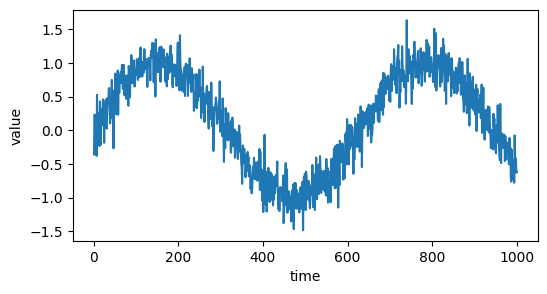

In [2]:
class Data:
    def __init__(self, T = 1000):
        self.time = torch.arange(1, T+1, dtype= torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2
data = Data()
plt.figure(figsize=(6, 3))
plt.plot(data.time, data.x)
plt.xlabel("time")
plt.ylabel("value")

# 9.2 Text -> Data

In [3]:
import os
import re
import requests
import collections

class TimeMachine:
    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000, root = "./data"):
        self.url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        self.root = root
        os.makedirs(self.root, exist_ok = True)
        self.filename = os.path.join(self.root, 'timemachine.txt')

        #download data -> preprocess -> tokenize -> indexes of vocab và vocab
        corpus, self.vocab = self.build(self._download())   # nhờ dòng này mà TimeMachine thành một class tự động

        array = torch.tensor([corpus[i:i+num_steps+1]
                        for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]  #X là các input đầu vào, Y là các output mong muốn

    def _download(self):
        if not os.path.exists(self.filename):
            print("Downloading dataset...")
            response = requests.get(self.url)
            with open(self.filename, 'w', encoding='utf-8') as f:
                f.write(response.text)
        with open(self.filename, 'r', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text):
        text = re.sub('[^A-Za-z]+', ' ', text).lower()
        return text
    def _tokenize(self, text):
        return list(text)
    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))     # raw_test -> preprocess -> tokenize = token
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens] # vocab[token] trả về indexes của các token trong vocab
                                                    # -> corpus là list các token sau khi thành indexes
        return corpus, vocab

    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)


In [4]:
class Vocab:
    def __init__(self, tokens = [], reserved_tokens = [], min_freq = 0):

        # đưa token từ 2D list về 1D list nếu cần thiết
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]

        # đây là hàm đếm thôi, đầu vào là list, đầu ra là dict
        counter = collections.Counter(tokens)
        # sort lại theo frequency để tiện theo dõi
        self.token_freqs = sorted(counter.items(), key = lambda x: x[1], reverse=True)

        # đầu tiên là cộng 3 list gồm ['<unk>'], reserved_tokens và token vào.
        # sau đó là đưa về set để loại bỏ đi các phần tử trùng lặp
        # sau đó sort rồi đưa về list thôi
        # TÁC DỤNG: đưa về list để có thể tra self.idx_to_token[i] để tìm token thứ i
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))

        # hơi ngược với idx_to_token vì nó làm điều ngược lại
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}



    def __len__(self):
        """
        trả về tổng số tokens (tính cả <unk>)
        """
        return len(self.idx_to_token)


    def __getitem__(self, tokens):
        """
        trả về một list các index của mọi token trong list tokens mình muốn
        """
        if not isinstance(tokens, (list, tuple)):               #nếu tokens của mình không phải list hay tuple
            return self.token_to_idx.get(tokens, self.unk)      # dict.get(a, default value) có nghĩa là nếu a
                                                                # tồn tại trong dict thì sẽ trả về dict[a],
                                                                # còn nếu không sẽ trả về default value
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        """
        Cho vào một list indexes mong muốn, trả về list tokens
        """
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']


In [5]:
data = TimeMachine(2, 32)
raw_text = data._download()
print(raw_text[:60])

﻿The Project Gutenberg eBook of The Time Machine
    
This e


In [6]:
text = data._preprocess(raw_text)
text[:60]

' the project gutenberg ebook of the time machine this ebook '

In [7]:
tokens = data._tokenize(text)
','.join(tokens[:30])

' ,t,h,e, ,p,r,o,j,e,c,t, ,g,u,t,e,n,b,e,r,g, ,e,b,o,o,k, ,o'

In [8]:
counter = collections.Counter(tokens)
token_freqs = sorted(counter.items(), key = lambda x: x[1])
print(token_freqs)

[('q', 106), ('z', 107), ('j', 186), ('x', 281), ('k', 1231), ('v', 1434), ('b', 2167), ('p', 2866), ('y', 3022), ('g', 3507), ('w', 3519), ('f', 3743), ('c', 4045), ('u', 4322), ('m', 4361), ('l', 6649), ('d', 6862), ('h', 8835), ('r', 8888), ('s', 9302), ('n', 11005), ('o', 11148), ('i', 11303), ('a', 12743), ('t', 15086), ('e', 19769), (' ', 35931)]


In [9]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [0, 21, 9, 6, 0, 17, 19, 16, 11, 6]
words: [' ', 't', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e']


In [10]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2477),
 ('and', 1311),
 ('of', 1285),
 ('i', 1268),
 ('a', 877),
 ('to', 766),
 ('in', 605),
 ('was', 554),
 ('that', 458),
 ('it', 452)]

In [11]:
corpus, vocab = data.build(raw_text)
corpus[:10], len(vocab)

([0, 21, 9, 6, 0, 17, 19, 16, 11, 6], 28)

In [12]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 344),
 ('in--the', 192),
 ('i--had', 130),
 ('and--the', 112),
 ('i--was', 112),
 ('the--time', 110),
 ('to--the', 101),
 ('it--was', 99),
 ('project--gutenberg', 88),
 ('as--i', 78)]

In [13]:
torch.randn(2, 2)

tensor([[ 1.2366, -0.4153],
        [-0.0592, -0.4600]])

# 9.5 RNNScratch

In [22]:
class RNNScatch(nn.Module):
    def __init__(self, dim_inputs, dim_hidden, sigma = 0.01):    #dim_inputs là số chiều để embedding input
                                                    #tương tự với dim_hidden
        super().__init__()
        self.dim_inputs = dim_inputs
        self.dim_hidden = dim_hidden
        self.W_xh = nn.Parameter(torch.randn((dim_inputs, dim_hidden)) * sigma)
        self.W_hh = nn.Parameter(torch.randn((dim_hidden, dim_hidden)) * sigma)
        self.b_h = nn.Parameter(torch.randn(1) * sigma)

    def forward(self, input, state = None):
        if state == None:
            state = torch.zeros((input.shape[1], self.dim_hidden)) #shape của input là [num_steps, batch_size, dim_inputs]
            # trong đó: num_steps là số token trong một input trong một lần xử lý
            #           batch_size là số câu đang xử lý song song
            # do đó nên batch_size cần phải giữ nguyên

        outputs = []
        for X in input: # là xử lý từng token trong input
            # X.shape = [batch_size, dim_inputs]
            state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state       #output should be the same length as num_steps

# test RNNScatch
dim_inputs, batch_size, dim_hidden, num_steps = 2, 16, 32, 100
X = torch.randn((num_steps, batch_size, dim_inputs))
rnn = RNNScatch(dim_inputs, dim_hidden)
outputs, state = rnn(X)
len(outputs), len(state)

(100, 16)

In [26]:
def check_len(a, n):
    """Check the length of a list."""
    assert len(a) == n, "the lenth is wrong"
def check_shape(a, shape):
    """Check the shape of a tensor."""
    assert a.shape == shape, "the shape is wrong"

# check len và check shape của output và state
check_len(outputs, len(X))
check_shape(outputs[0], (batch_size, dim_hidden))
check_shape(state, (batch_size, dim_hidden))